In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import scipy as sp
import scipy.stats
import time
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader
    

from pydrake.all import (RigidBodyTree, RigidBody)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
DATA_FILE = "data/20180626_uniform_feasible_1000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))

Loaded 1000 environments from file data/20180626_uniform_feasible_1000.yaml


In [59]:
# Make a listing of the observed classes
class_name_to_index_map = {}
class_index_to_name_map = []
current_ind = 0
for env_name in environments.keys():
    env = environments[env_name]
    for k in range(env["n_objects"]):
        class_name = env["obj_%04d" % k]["class"]
        if class_name not in class_name_to_index_map:
            class_name_to_index_map[class_name] = current_ind
            class_index_to_name_map.append(class_name)
            current_ind += 1
print class_name_to_index_map, class_index_to_name_map
N_CLASSES = current_ind

{'small_box': 0} ['small_box']


Selection of environments from original distribution


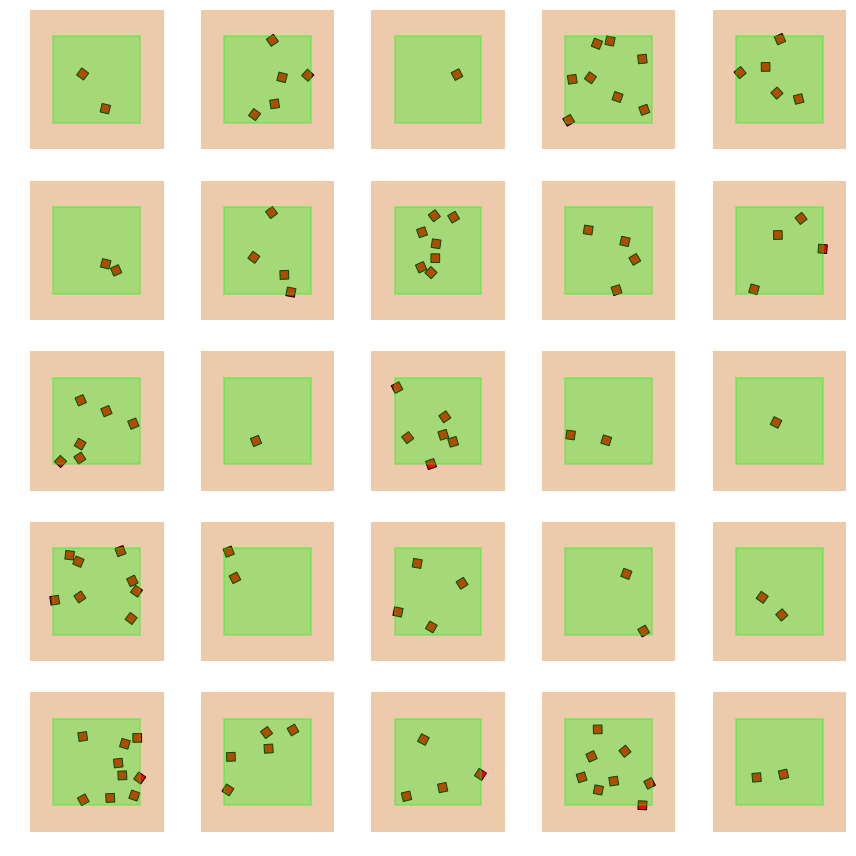

In [62]:
# Draw a few example scenes from the set
import generate_planar_scene_arrangements as psa_utils

def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)

plt.figure().set_size_inches(12, 12)
print "Selection of environments from original distribution"
N = 5
for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments["env_%04d" % (i*N+j)], plt.gca())
        plt.grid(True)
plt.tight_layout()

## Fitting distributions to generated scene data

Referencing discussion from the 20180621 notebook -- one way to tackle this would be to treat each object as occuring independently of other objects. That is, we're ultimately interested in sampling a number of objects $n$, a set of object classes $c_i$, and a set of object poses $p_i$ $\{[c_0, p_0], ..., [c_n, p_n]\}$. They have joint distribution $p(n, c, p)$, which we factorize $p(n)\Pi_i\left[p(p_i | c_i)p(c_i)\right]$ -- that is, draw the number of objects and class of each object independently, and then draw each object pose independently based on a class-specific distribution.

So the distributions we need to fit are:

- The distribution of object number $p(n)$, which we'll just draw up a histogram
- The distribution of individual object class $p(c_i)$, which we'll also just draw up a histogram
- The distribution of object pose based on class $p(p_i | c_i)$, which we'll fit with KDE

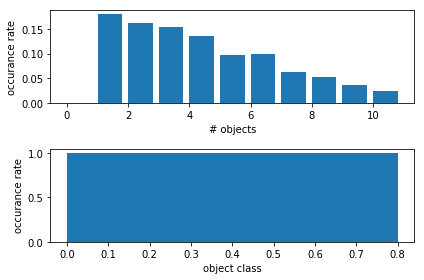

In [37]:
# Get statistics for # object occurance rate and classes
object_number_occurances = np.zeros(N_ENVIRONMENTS)
object_class_occurances = np.zeros(N_CLASSES)
for i in range(N_ENVIRONMENTS):
    env = environments["env_%04d" % i]
    object_number_occurances[i] = env["n_objects"]
    for k in range(env["n_objects"]):
        object_class_occurances[
            class_name_to_index_map[env["obj_%04d" % k]["class"]]] += 1
n_hist, n_hist_bins = np.histogram(object_number_occurances,
    bins=range(int(np.ceil(np.max(object_number_occurances)))+2))
n_pdf = n_hist.astype(np.float64)/np.sum(n_hist)
plt.subplot(2, 1, 1)
plt.bar(n_hist_bins[:-1], n_pdf, align="edge")
plt.xlabel("# objects")
plt.ylabel("occurance rate")

plt.subplot(2, 1, 2)
class_pdf = object_class_occurances / np.sum(object_class_occurances)
plt.bar(range(N_CLASSES), class_pdf, align="edge")
plt.xlabel("object class")
plt.ylabel("occurance rate")
plt.tight_layout()

Computing KDE for class 0
Class 0, Theta=0.000000, Max Likelihood Anywhere: 0.103906
Class 0, Theta=0.785398, Max Likelihood Anywhere: 0.176390
Class 0, Theta=1.570796, Max Likelihood Anywhere: 0.186868
Class 0, Theta=2.356194, Max Likelihood Anywhere: 0.179642
Class 0, Theta=3.141593, Max Likelihood Anywhere: 0.178878
Class 0, Theta=3.926991, Max Likelihood Anywhere: 0.180096
Class 0, Theta=4.712389, Max Likelihood Anywhere: 0.183231
Class 0, Theta=5.497787, Max Likelihood Anywhere: 0.162153


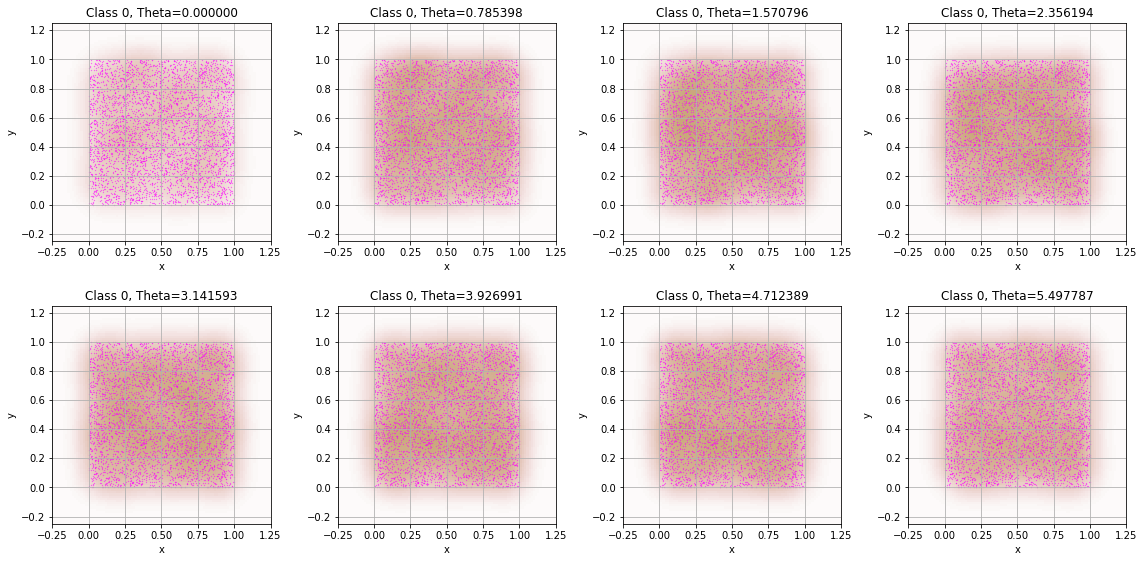

In [68]:
# Build statistics for object poses per each object class
object_poses_per_class = []
# Useful to have for preallocating occurance vectors
max_num_objects_in_any_environment = int(np.max(object_number_occurances))
for class_k in range(N_CLASSES):
    # Overallocate, we'll resize when we're done
    poses = np.zeros((3, max_num_objects_in_any_environment*N_ENVIRONMENTS))
    total_num_objects = 0
    for i in range(N_ENVIRONMENTS):
        env = environments["env_%04d" % i]
        for k in range(env["n_objects"]):
            obj = env["obj_%04d" % k]
            if class_name_to_index_map[obj["class"]] == class_k:
                poses[:, total_num_objects] = obj["pose"][:]
                total_num_objects += 1
    object_poses_per_class.append(poses[:, :total_num_objects])

class_kde_fits = []
tslices = np.linspace(0., 2*np.pi, 8, endpoint=False)
plt.figure().set_size_inches(16, 8)
plt.title("Distribution over space, per object class")
for class_k in range(N_CLASSES):
    print("Computing KDE for class %d" % class_k)
    poses = object_poses_per_class[class_k]
    kde_fit = sp.stats.gaussian_kde(poses)
    class_kde_fits.append(kde_fit)
    
    for slice_k, tslice in enumerate(tslices):
        xmin = -0.25
        xmax = 1.25
        ymin = -0.25
        ymax = 1.25
        N = 100j
        X, Y = np.mgrid[xmin:xmax:N, ymin:ymax:N]
        positions = np.vstack([X.ravel(), Y.ravel(), np.zeros(X.ravel().shape) + tslice])
        Z = np.reshape(kde_fit(positions).T, X.shape)

        print "Class %d, Theta=%f, Max Likelihood Anywhere: %f" %(class_k, tslice, np.max(Z))
        plt.subplot(N_CLASSES*2, 4, class_k+1 + slice_k)
        plt.title("Class %d, Theta=%f" % (class_k, tslice))
        plt.gca().imshow(np.rot90(Z[:, :]), vmin=0., vmax=1.,
                         cmap=plt.cm.gist_earth_r,
                         extent=[xmin, xmax, ymin, ymax])
        plt.scatter(poses[0, :], poses[1, :], s=0.05, c=[1., 0., 1.])
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)

plt.tight_layout()

As expected, this fits the uniform distribution of classes over space pretty well, though it does have trouble dealing with the angle wraparound (observe that the likelihood drops off at theta=0 to almost half of what it is elsewhere). Not too surprising, as that's on the "border" of the observed samples. Would have to use a specialized KDE tool to handle that down the road.

## Sampling new scenes from this data

We can generate new scenes by sampling up the dependency tree:

1) First sample # of objects

2) Then sample a class for every object, independently

3) Given each object's class, sample its location

We can also evaluate the likelihood of each generated sample
to get an idea how "typical" they are, by finding the likelihood
of each object given its generated position and class and combining
them. However, we have to normalize by the maximum possible likelihood
for an object of that class for every object for the comparison between
two sets of objects to make sense.

Classwise max likelihoods:  [0.1870727]
TODO: Log likelihood is still probably wrong... the scaling with N is weird.


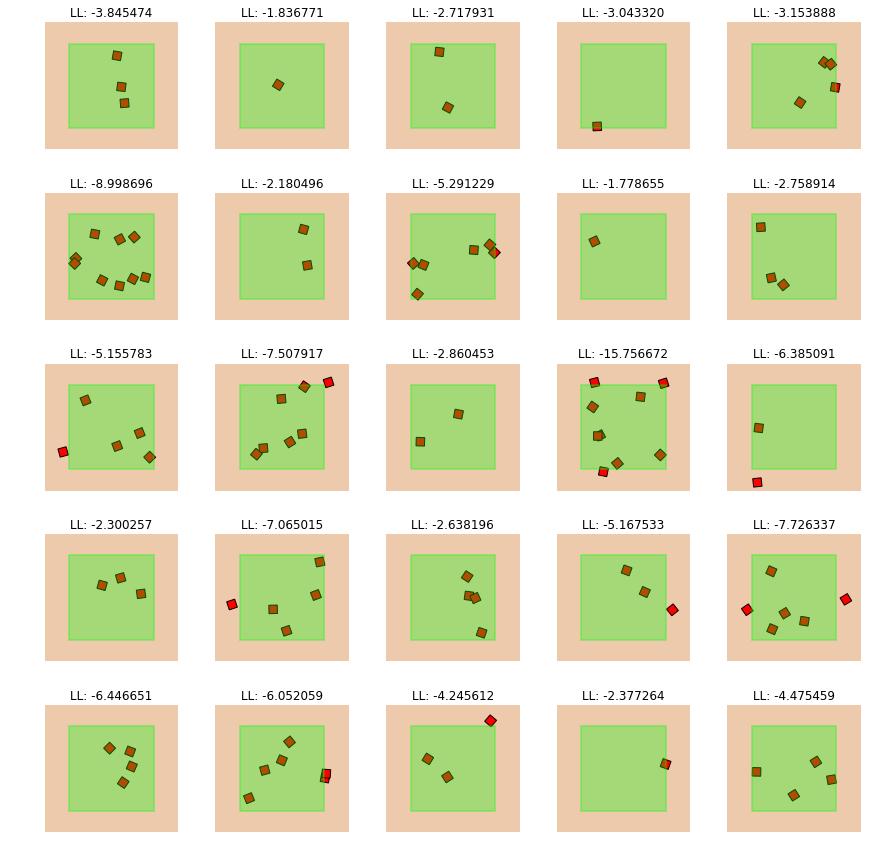

In [61]:
n_cdf = np.cumsum(n_pdf)
class_cdf = np.cumsum(class_pdf)

# Calculate maximum likelihood value for each class
classwise_max_likelihoods = np.zeros(N_CLASSES)
for i in range(N_CLASSES):
    # Evaluate the PDF at a bunch of sample points
    xmin = 0.
    xmax = 1.
    ymin = 0.
    ymax = 1.
    tmin = 0.
    tmax = 2.*np.pi
    N = 20j
    X, Y, T = np.mgrid[xmin:xmax:N, ymin:ymax:N, tmin:tmax:N]
    positions = np.vstack([X.ravel(), Y.ravel(), T.ravel()])
    classwise_max_likelihoods[i] = (np.max(class_kde_fits[i](positions)))

print "Classwise max likelihoods: ", classwise_max_likelihoods

plt.figure().set_size_inches(12, 12)
plt.title("Generated environments matching original distribution")
np.random.seed(42)
N = 5
for i in range(N):
    for j in range(N):
        total_log_likelihood = 0.
        n_objects = np.argmax(n_cdf >= np.random.random())
        total_log_likelihood += np.log(n_pdf[n_objects])
        environment = {"n_objects": n_objects}
        lln = 0
        for object_k in range(n_objects):
            obj_name = "obj_%04d" % object_k
            obj_class = np.argmax(class_cdf >= np.random.random())
            total_log_likelihood += np.log(class_pdf[obj_class] / np.max(class_pdf))
            obj_pose = class_kde_fits[obj_class].resample([1])
            total_log_likelihood += (class_kde_fits[obj_class].logpdf(obj_pose) -
                                     np.log(classwise_max_likelihoods[obj_class]))
            environment[obj_name] = {"pose": obj_pose,
                                     "class": class_index_to_name_map[obj_class]}
        
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environment, plt.gca())
        plt.grid(True)
        plt.title("LL: %f" % total_log_likelihood)
        plt.xlim(-0.25, 1.25)
        plt.ylim(-0.25, 1.25)

print "TODO: Log likelihood is still probably wrong... the scaling with N is weird."
plt.tight_layout()

As in the previous notebook for truly independent objects, I attempt to calculate log likelihood scores for each arrangement by calculating

$$ p(c, p, n) = p(n) * {\Large \Pi_{i}^{n}} \left[ \dfrac{p(p_i | c_i)}{\max_{\hat{p}}{p(\hat{p} | c_i})} \dfrac{p(c_i)}{\max_{\hat{c}} p(c)} \right] $$ 

(which includes normalization on a per-object and per-class basis to make comparison between scenes with different N possible). But I'm not convinced this is right, yet...

This clearly violates collision constraints, though, and would be hopeless to capture other inter-object interactions. Nonpenetration itself is an inter-object interaction, and should be handled as such.

## Investigating inter-object interactions

Let's refactorize a bit more carefully, instead breaking down $p(p, c)$ into a combination of pairwise terms.

$$ \begin{align} 
p(c, p, n) &= p(n) * \Pi_{ (i, j) \in [0...N]\times[0...N]} \left[ p(p_i, p_j, c_i, c_j) \right] \\
&= p(n) * \Pi_{ (i, j) \in [0...N]\times[0...N]} \left[ p(p_i - p_j | p_j, c_i, c_j) p(p_j | c_i, c_j) p(c_j | c_i) p(c_i) \right] \\
&= p(n) * \Pi_{ (i, j) \in [0...N]\times[0...N]} \left[ p(p_i - p_j | c_i, c_j) p(p_j | c_i, c_j) p(c_j | c_i) p(c_i) \right]
\end{align} $$

Here $p(p_i - p_j | c_i, c_j)$ describes the probability of the $i^{th}$ object being in various locations relative to a $j^{th}$ object, given both of their classes. This is assumed to be *independent* of the location of the $j^{th}$ object, for tractibility. We account for the position of the $j^{th}$ object with the distribution $p(p_j | c_i, c_j)$, which encodes what places the $j^{th}$ object is likely to be given that it's of class $c_j$ and will be 